In [65]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D , MaxPool2D , Dense , Flatten , InputLayer , BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy


In [76]:
dataset , dataset_info = tfds.load('malaria',with_info=True , as_supervised=True , shuffle_files= True , split=['train'])

In [77]:
for data in dataset[0].take(1):
    print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [78]:
dataset
# dataset_info

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [79]:
def splits(dataset , train_ratio , val_ratio , test_ratio):
    dataset_size = len(dataset)
    train_size = dataset.take(int(dataset_size * train_ratio))

    val_test_dataset = dataset.skip(int(dataset_size * train_ratio))
    val_dataset = val_test_dataset.take(int(val_ratio*dataset_size))

    test_dataset = val_test_dataset.skip(int(dataset_size * test_ratio))
    return train_size , val_dataset , test_dataset


In [80]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_dataset , val_dataset , test_dataset = splits(dataset[0], train_ratio , val_ratio , test_ratio)


In [81]:
train_dataset
# test_dataset
# val_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

2025-01-23 15:37:43.399697: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


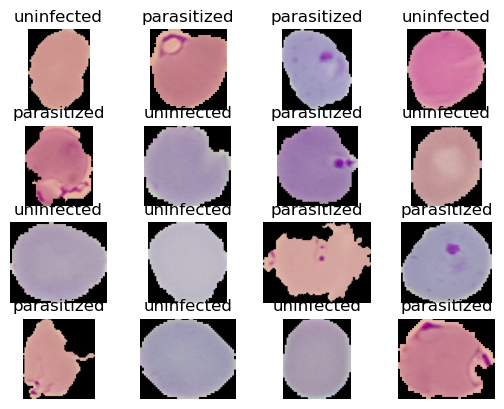

In [55]:
for i, (image , label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

In [56]:
dataset_info.features['label'].int2str(1)

'uninfected'

In [57]:
image_size = 224
def resize_rescale(image , label):
    return tf.image.resize(image , (image_size,image_size))/255.0 , label

In [82]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [59]:
for image , label in train_dataset.take(1):
    print(image , label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [60]:
train_dataset = train_dataset.shuffle(buffer_size= 8 , reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size= 8 , reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [61]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [62]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (image_size , image_size , 3)),
    tf.keras.layers.Conv2D(filters = 6 , kernel_size=3 , strides= 1 , padding="valid" , activation ="relu"),
    MaxPool2D(pool_size= 2 , strides= 2),
    BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 16 , kernel_size=3 , strides= 1 , padding="valid" , activation ="relu"),
    MaxPool2D(pool_size= 2 , strides= 2),
    BatchNormalization(),
    Flatten(),
    Dense(100 , activation="relu"),
    BatchNormalization(),
    Dense(10 , activation="relu"),
    BatchNormalization(),
    Dense(1 , activation="sigmoid"),
])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 111, 111, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 54, 54, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

In [66]:
model.compile(optimizer= Adam(learning_rate= 0.01) , loss= BinaryCrossentropy(),metrics = ["accuracy"])

In [68]:
history = model.fit(train_dataset ,validation_data= val_dataset ,epochs= 20 , verbose= 1)

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 73s 105ms/step - accuracy: 0.9476 - loss: 0.1569 - val_accuracy: 0.9027 - val_loss: 0.5417
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 77s 111ms/step - accuracy: 0.9497 - loss: 0.1577 - val_accuracy: 0.9426 - val_loss: 0.6818
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 80s 116ms/step - accuracy: 0.9542 - loss: 0.1395 - val_accuracy: 0.9401 - val_loss: 0.2029
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 80s 116ms/step - accuracy: 0.9616 - loss: 0.1170 - val_accuracy: 0.9456 - val_loss: 0.1691
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 81s 118ms/step - accuracy: 0.9655 - loss: 0.0997 - val_accuracy: 0.9328 - val_loss: 0.7263
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 82s 120ms/step - accuracy: 0.9666 - loss: 0.0937 - val_accuracy: 0.9430 - val_loss: 0.2369
Epoch 7/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 82s 119ms/step - accuracy: 0.9778 - loss: 0.0651 - val_accuracy: 0.9383 - val_loss: 0.2549
Epoch 8/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 81s 118ms/step - accuracy: 0.9825 - loss: 0

In [69]:
model.save("VSCode Saved Malaria Model.keras")

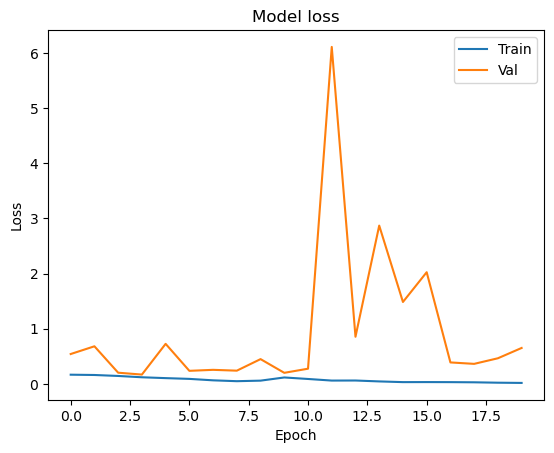

In [95]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.savefig("Model_Loss.png")
plt.show()

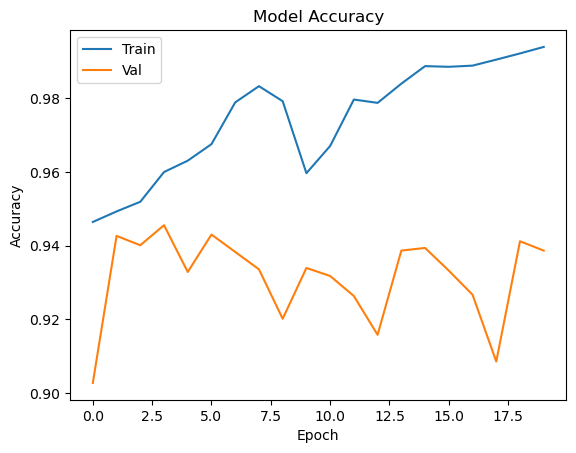

In [96]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.savefig("Model_Accuracy.png")
plt.show()

In [84]:
test_dataset = test_dataset.batch(1)

In [89]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [86]:
model.evaluate(test_dataset)

2757/2757 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9413 - loss: 0.6612


[0.6707648634910583, 0.9383387565612793]

In [90]:
model.predict(test_dataset.take(1))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


0.9999907

In [91]:
def parasite_or_not(X):
    if X<0.5:
        return str("P")
    else:
        return str("U")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


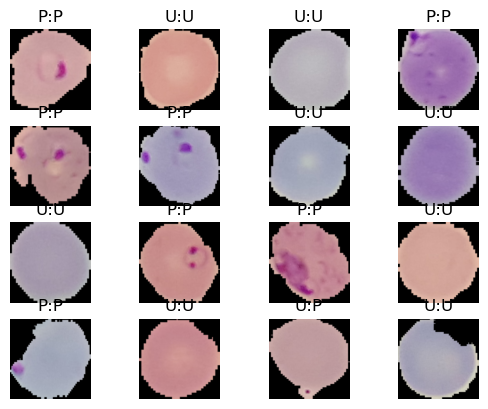

In [103]:
for i , (image , label) in enumerate(test_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    ax.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0]))+":"+str(parasite_or_not(model.predict(image)[0][0])))
    plt.axis('off')
